Primero vamos a realizar la conexión con Docker utilizando el puerto 3306

In [66]:
import mariadb
import sys

config = {
    'host': '127.0.0.1',
    'port': 3306,
    'user': 'root',
    'password': 'root',
    'database': 'employees'
}


In [67]:
# conexión a MariaDB
try:
    conn = mariadb.connect(**config)

except mariadb.Error as e:
    print(f"Error para conectarse con Maria DB: {e}")
    sys.exit(1)

# Enable Auto-Commit
conn.autocommit = True

# create a connection cursor
cur = conn.cursor()

Realizamos el query. Vamos a importar 10 mil datos. Para realizar lo que se pide en la tarea, necesitamos los salarios de un título en específico, así como las fechas. En este caso, se realizará con el puesto de 'senior engineer'

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

query = """
SELECT titles.title, salaries.salary, salaries.from_date
FROM titles
INNER JOIN salaries ON titles.emp_no=salaries.emp_no
WHERE titles.title="Senior Engineer"
limit 10000;"""

df=pd.read_sql(query,conn)
df.to_csv('empleos.csv')
df

c:\Users\52333\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,title,salary,from_date
0,Senior Engineer,60117,1986-06-26
1,Senior Engineer,62102,1987-06-26
2,Senior Engineer,66074,1988-06-25
3,Senior Engineer,66596,1989-06-25
4,Senior Engineer,66961,1990-06-25
...,...,...,...
9995,Senior Engineer,92424,1990-08-22
9996,Senior Engineer,54083,1986-06-14
9997,Senior Engineer,54484,1987-06-14
9998,Senior Engineer,58120,1988-06-13


Ahora vamos a ver qué tipo de datos tenemos

In [69]:
df.dtypes

title        object
salary        int64
from_date    object
dtype: object

Observemos que la fecha tiene como tipo de dato 'objeto' y para realizar los cálculos, necesitamos tener un valor numérico. Para ello, primero convertimos esa columna a un pandas date time. Después cambiamos al valor ordinal Gregoriano de nuestras fechas.

In [70]:
import datetime as dt

df['from_date'] = df['from_date'].astype('datetime64[ns]')
df['from_date'] = df['from_date'].apply(dt.datetime.toordinal)
df


,title,salary,from_date
0,Senior Engineer,60117,725183
1,Senior Engineer,62102,725548
2,Senior Engineer,66074,725913
3,Senior Engineer,66596,726278
4,Senior Engineer,66961,726643
...,...,...,...
9995,Senior Engineer,92424,726701
9996,Senior Engineer,54083,725171
9997,Senior Engineer,54484,725536
9998,Senior Engineer,58120,725901


Ahora extraemos la columna del dataframe en un numpy.ndarray. Al imprimir el dataframe, se notó que la columna de salarios y los valores ordinales de las fechas difieren en un orden de magnitud, por lo que se aplicará una normalización (como es una transformación lineal no afecta la correlación de nuestras variables)

In [71]:
import numpy as np
import jax.numpy as jnp
xs=df['from_date'].to_numpy()
ys=df['salary'].to_numpy()
xs=(xs-jnp.min(xs))/(jnp.max(xs)-jnp.min(xs))
ys=(ys-jnp.min(ys))/(jnp.max(ys)-jnp.min(ys))


Vamos a definir nuestro modelo lineal. Como loss function utilizaremos el mean square error. Y los pesos (en este caso el valor de la pendiente y del bias) se actualizan restandole al peso anterior el gradiente de la loss function con respecto al peso correspondiente, multiplicando por un cierto learning rate. En jax.grad() argnums se utiliza para especificar respecto a qué variable es la derivada.

In [72]:
import jax
import jax.numpy as jnp

def modelo(m,b,x):
    return m*x+b

def loss(m,b,x,y):
    prediccion=modelo(m,b,x)
    return jnp.mean((prediccion-y)**2)

def update(m,b,x,y,lr):
    m=m-lr*jax.grad(loss,argnums=0)(m,b, x, y)
    b=b-lr*jax.grad(loss,argnums=1)(m,b, x, y)
    return m,b

In [73]:
m=1.
b=1.
lr=5e-3
epsilon=2.5e-2
max_step=2000
loss_vec=np.array([]) #aquí guardaremos el valor del loss para luego graficarlo
import numpy as np
import matplotlib.pyplot as plt


for i in range(1,10000):
    m=update(m,b,xs,ys,lr)[0]
    b=update(m,b,xs,ys,lr)[1]
    loss_value=loss(m,b,xs,ys)
    loss_vec=np.append(loss_vec,loss_value)
    if (i%20==0):
        print('Paso: {}, Pendiente: {:.3f}, Bias {:.3f}, Loss{:.3f}'.format(i,m,b,loss_value))
    if (loss_value<epsilon or i==max_step ):
        print('Se llegó a la solución en el paso numero:',i)
        break
print(m,b)


Paso: 20, Pendiente: 0.847, Bias 0.765, Loss1.079
Paso: 40, Pendiente: 0.732, Bias 0.588, Loss0.628
Paso: 60, Pendiente: 0.644, Bias 0.454, Loss0.370
Paso: 80, Pendiente: 0.578, Bias 0.352, Loss0.223
Paso: 100, Pendiente: 0.527, Bias 0.276, Loss0.138
Paso: 120, Pendiente: 0.489, Bias 0.218, Loss0.090
Paso: 140, Pendiente: 0.460, Bias 0.174, Loss0.062
Paso: 160, Pendiente: 0.437, Bias 0.141, Loss0.046
Paso: 180, Pendiente: 0.420, Bias 0.117, Loss0.037
Paso: 200, Pendiente: 0.407, Bias 0.098, Loss0.032
Paso: 220, Pendiente: 0.397, Bias 0.084, Loss0.029
Paso: 240, Pendiente: 0.390, Bias 0.074, Loss0.027
Paso: 260, Pendiente: 0.384, Bias 0.066, Loss0.026
Paso: 280, Pendiente: 0.379, Bias 0.060, Loss0.026
Paso: 300, Pendiente: 0.375, Bias 0.056, Loss0.025
Paso: 320, Pendiente: 0.372, Bias 0.052, Loss0.025
Paso: 340, Pendiente: 0.370, Bias 0.050, Loss0.025
Se llegó a la solución en el paso numero: 354
0.36837697 0.04886215


Y ahora graficamos

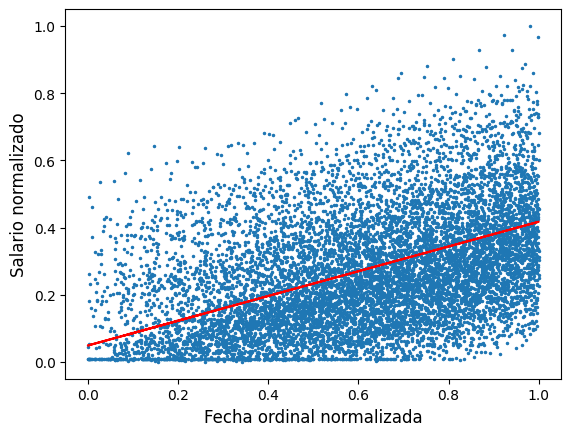

In [74]:
yf=modelo(m,b,xs)
plt.plot(xs,ys,'.',markersize=3)
plt.plot(xs,yf,'r',markersize=5)
plt.xlabel('Fecha ordinal normalizada',fontsize=12)
plt.ylabel('Salario normalizado',fontsize=12)

plt.show()


Text(0, 0.5, 'Loss function')

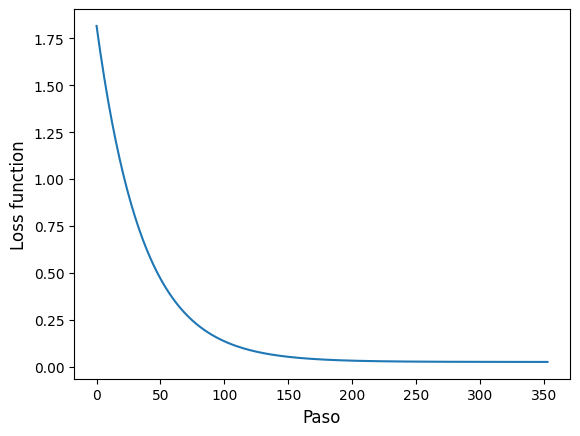

In [75]:
#graficamos la función loss
plt.plot(loss_vec)
plt.xlabel('Paso',fontsize=12)
plt.ylabel('Loss function',fontsize=12)


Ahora vamos a realizar nuestra predicción

In [76]:
import datetime
hoy=datetime.date.today()
hoy=hoy.toordinal()
xs0=df['from_date'].values
ys0=df['salary'].values
#tenemos que normalizar para poder utilizar nuestro modelo
hoy_n=(hoy-jnp.min(xs0))/(jnp.max(xs0)-jnp.min(xs0))
salario_hoy=modelo(m,b,hoy_n)
salario_hoy=(salario_hoy)*(jnp.max(ys0)-jnp.min(ys0))+jnp.min(ys0)
print('el salario hoy de un Senior Engineer seria: $',salario_hoy)

el salario hoy de un Senior Engineer seria: $ 109263.73


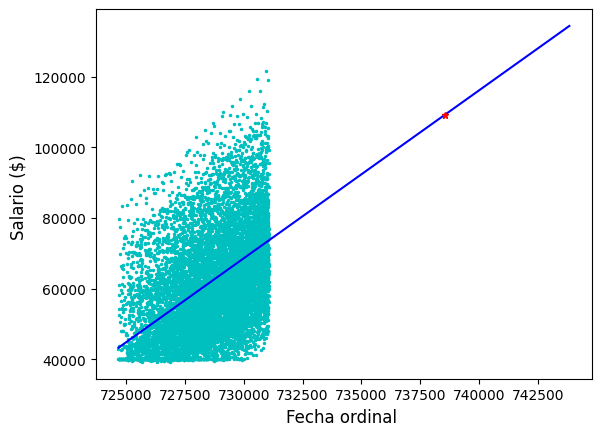

In [77]:
#ahora vamos a graficar todo sin normalizar

x=jnp.linspace(0,3,300)
yf=modelo(m,b,x)

#desnormalizamos la x y la y de la predicción
x=x*(jnp.max(xs0)-jnp.min(xs0))+jnp.min(xs0)
yf=yf*(jnp.max(ys0)-jnp.min(ys0))+jnp.min(ys0)
plt.plot(xs0,ys0,'.c',markersize=3)
plt.plot(x,yf,'b',markersize=5)
plt.xlabel('Fecha ordinal ',fontsize=12)
plt.ylabel('Salario ($) ',fontsize=12)
plt.plot(hoy,salario_hoy,'*r',markersize=5)

plt.show()

